# Algorithm 2: for Brownian bridge prior, double well TPS posterior

This algorithm is based on nonequlibrium dynamics, and runs SPDE with adjustment, with reweighting on the sampled trajectories, but no NN training.


In [1]:
import sys 
import os

sys.path.append("../src/")
import jax.numpy as jnp
import jax
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(500)

import matplotlib.pyplot as plt
import numpy as np
from path_sampling import make_double_well_potential, sample_sde
from spde import make_discrete_laplacian

In [2]:

J_tilde = lambda xts, grad_V, dt: jnp.sum(-dt*jax.vmap(lambda xt: 0.25*grad_V(xt).dot(grad_V(xt)) - 0.5*jnp.trace(jax.jacfwd(lambda k: grad_V(k))(xt)) )(xts))

def pi(xts, grad_V, s, hyperparams):
    dt = hyperparams['dt']
    A = make_discrete_laplacian(hyperparams['num_steps'], dt)
    part1 = s*J_tilde(xts, grad_V, dt)
    part2 = jnp.sum(0.25*dt*jax.vmap(lambda xt: xt @ A @ xt , in_axes=-1)(xts))
    return part1 + part2


# main loop
def step(xts, potential, s, ds, A, key, hyperparams, mh=False, prior= 'brownian'):

    grad_V = lambda x: jax.grad(potential)(x)

    u = lambda x: -s*grad_V(x)   # current annealed potential

    dt = hyperparams['dt']
    discrete_laplacian = make_discrete_laplacian(hyperparams['num_steps'], dt)

    I = jnp.eye(hyperparams['num_steps'])
    L = (I - 0.25*ds*discrete_laplacian)
    R =  (I + 0.25*ds*discrete_laplacian)
    # L = I
    # R  = I + 0.5*ds*discrete_laplacian
    L_inv = jnp.linalg.inv(L)

    jacobian_u = jax.jacfwd(u)

    M_part_1 = -0.5*ds*jax.vmap(lambda k: jacobian_u(k) @ u(k))(xts)
    M_part_2 = -0.5*ds*jax.vmap(jax.grad(lambda k: jnp.trace(jacobian_u(k))))(xts)

    noise = jnp.sqrt(2 * (ds/dt))*jax.random.normal(key, shape=xts.shape)

    xts_ds = L_inv @ (R @ xts + M_part_1 + M_part_2 + noise)

    
    # brownian bridge prior is used here
    if prior=='brownian':
        xts_ds = xts_ds.at[0].set(-1)
        xts_ds = xts_ds.at[-1].set(1)
    elif prior=='sde_prior':
        sigma = 0.1   
        xts_ds = xts_ds.at[0].set(-1)
        xts_ds = xts_ds.at[-1].set(xts_ds[-2])
        #xts_ds = xts_ds.at[-1].set(xts_ds[-2] + dt*(u(xts_ds[-2]) + ((2.*s)/(sigma**2) )*((1 - xts_ds[-2])) )) 

    def q(xts, xts_prime):
        return (-(dt/(4*ds))*jnp.linalg.norm(L@xts_prime - R@xts + (M_part_1 + M_part_2))**2)

    if mh:
        log_W = (pi(xts_ds, grad_V, s, hyperparams)+q(xts_ds, xts)) - (pi(xts, grad_V, s, hyperparams)+q(xts, xts_ds))
        accept_prob = jnp.clip(jnp.exp(log_W), 0., 1.)

        accept = jax.random.uniform(key) < accept_prob
        # jax.debug.print("{accept}", accept=accept)
        xts_ds = xts_ds*accept + xts*(1-accept)

    A = A - ds*J_tilde(xts_ds, grad_V, dt)

    return xts_ds, A



def refine_spde(xts, V, s, A, num_steps, key, ds, hyperparams, mh, prior= 'brownian'):

    for i in range(num_steps):
        key = jax.random.fold_in(key, i)
        xts, A = step(
            xts=xts,
            potential=V,  # prior potential
            A=A,
            s=s,
            key=key,
            ds=ds,
            hyperparams=hyperparams,
            mh=mh,
            prior=prior
        )

    return xts, A

In [3]:

key = jax.random.key(0)

hyperparams={'dt': 0.1, 'num_steps': 100, 'num_training_steps' : 200}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']

ndims = 1


## draw an initial path
# path_key = jax.random.key(1)
# xs, times = jax.pmap(lambda key:sample_sde(
#     b=lambda x,t: 0.0, 
#     W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
#     rho = lambda key: jnp.zeros((ndims,))-1.,
#     key=key, 
#     dt=hyperparams['dt'], 
#     num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 10))


## a double well potential
# u = lambda x: -jax.grad(make_double_well_potential(v=5.0))(x)

    
# xts, A = jax.pmap(lambda key, path: refine_spde(
#     xts=path,
#     # V=make_double_well_potential(v=5.0),
#     V=lambda x: 0.0,
#     s=0.0,
#     num_steps=100,
#     key=key,
#     ds=0.001,
#     hyperparams=hyperparams,
#     A=0,
#     mh=False,
#     prior='brownian'
# ))(jax.random.split(jax.random.key(0), 10), xs)

# # # plot xs[0]
# for x in xs:
#     plt.plot(x, time, label='sampled')

# for x in xts:
#     plt.plot(x, time, label='sampled')



## Algorithm 2

Single SPDE step with chaning potential + MH adjustment.


0.49247876
0.5885932
0.67955667
0.81646615
0.94243336
1.0980567
1.2571274
1.5323418
1.8309876


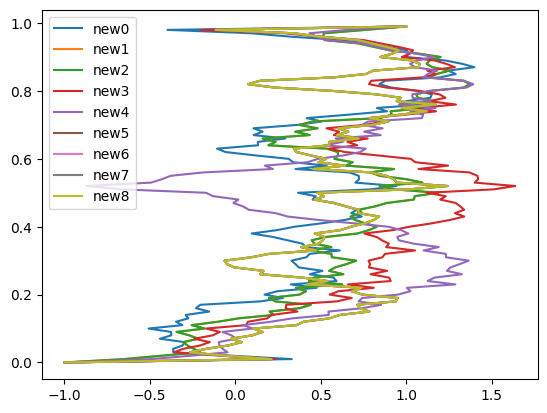

In [6]:
ensemble_size = 10

key = jax.random.key(0)

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 200}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']

ndims = 1

brownian_bridge_drift = lambda x,t: (1 - x)/(1-t)  # condition on hitting +1 at time 1


# initial draw from Brownian Bridge
path_key = jax.random.key(1)
xts, times = jax.pmap(lambda key:sample_sde(
    b=brownian_bridge_drift, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,   # initial distribution
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, ensemble_size))

# for path in xts:
#     # plot
#     plt.plot(path, times[0], label='old', color='black')


A = 0
Z_ratio = 0
schedule = np.linspace(0,1,9)

for i,s in enumerate(schedule):

    xts, A = jax.pmap(lambda k, path: refine_spde(
        xts=path,
        V=make_double_well_potential(v=5.0),
        s=s,
        ds=1e-2,   # stepsize for SPDE
        A=A,
        key=key,
        hyperparams=hyperparams,
        mh=True,
        prior='brownian',
        num_steps=1,   # 1 step only
    ))(jax.random.split(jax.random.key(0), ensemble_size), xts)

    plt.plot(xts[0], times[0], label=f'new{i}')

    plt.legend()

    # is this correct?
    A = (jnp.mean(A))
    Z_ratio += jnp.exp(A)
    print(A)

Z_ratio = Z_ratio/len(schedule)
